# Выбор локации для скважины

Мы работаем в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. Нужно построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль.

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков.
- Строят модель и оценивают объём запасов.
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины.
- Прибыль равна суммарной прибыли отобранных месторождений.

План проекта:
- загрузить и подготовить данные для анализа
- разбить данные на обучающую и валидационную выборки
- обучить и проверить модели Линейной регрессии для каждого региона
- посчитать средний запас предсказанного сырья и RMSE модели
- рассчитать достаточный объём сырья для безубыточной разработки новой скважины и сравнить полученный объём сырья со средним запасом в каждом регионе
- написать функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели
- посчитать риски и прибыль для каждого региона:
    - применить технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли
    - найти среднюю прибыль, 95%-й доверительный интервал и риск убытков (отрицательную прибыль)
- предложить регион для разработки скважин

Условия задачи:
1. Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
2. При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
3. Бюджет на разработку скважин в регионе — 10 млрд рублей.
4. При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
5. После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Описание данных:
- данные геологоразведки трёх регионов находятся в трех файлах
- id — уникальный идентификатор скважины
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы)
- product — объём запасов в скважине (тыс. баррелей)

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка-и-подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Изучение-данных" data-toc-modified-id="Изучение-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Изучение данных</a></span></li><li><span><a href="#Разбитие-данных-на-выборки" data-toc-modified-id="Разбитие-данных-на-выборки-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Разбитие данных на выборки</a></span></li><li><span><a href="#Масштабирование-признаков" data-toc-modified-id="Масштабирование-признаков-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Масштабирование признаков</a></span></li></ul></li><li><span><a href="#Обучение-и-проверка-модели" data-toc-modified-id="Обучение-и-проверка-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение и проверка модели</a></span><ul class="toc-item"><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Проверка-модели" data-toc-modified-id="Проверка-модели-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Проверка модели</a></span></li></ul></li><li><span><a href="#Подготовка-к-расчёту-прибыли" data-toc-modified-id="Подготовка-к-расчёту-прибыли-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка к расчёту прибыли</a></span></li><li><span><a href="#Расчёт-прибыли-и-рисков" data-toc-modified-id="Расчёт-прибыли-и-рисков-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Расчёт прибыли и рисков</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

## Загрузка и подготовка данных

### Изучение данных

Подключим все необходимые библиотеки и функции. Загрузим файлы и изучим данные.

In [1]:
import pandas as pd
import numpy as np

# для разделения выборки на обучающую и валидационную
from sklearn.model_selection import train_test_split
# для масштабирования признаков
from sklearn.preprocessing import StandardScaler

# для модели Линейная регрессия
from sklearn.linear_model import LinearRegression
# для метрики RMSE
from sklearn.metrics import mean_squared_error

In [2]:
data1 = pd.read_csv('/datasets/geo_data_0.csv')
data2 = pd.read_csv('/datasets/geo_data_1.csv')
data3 = pd.read_csv('/datasets/geo_data_2.csv')
data1.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [3]:
data2.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [4]:
data3.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Нам нужно определить регион, где добыча принесёт наибольшую прибыль. Следовательно перед нами задача регрессии.

Рассмотрим подробную информацию о данных во всех файлах: количество записей, столбцов, пропусков, типы данных.

In [5]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [7]:
data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Во всех трех файлах одинаковое количество строк, ячеек, одинаковые типы данных и названия столбцов, пропусков нет.

Столбцы 'id' не несут никакой ценности для обучения модели, удалим их, предварительно проверив на наличие дубликатов (их нет).

In [8]:
# проверка на дубликаты
print(data1.duplicated().sum())
print(data2.duplicated().sum())
print(data3.duplicated().sum())

0
0
0


In [9]:
data1.drop(['id'], axis = 1, inplace= True)
data2.drop(['id'], axis = 1, inplace= True)
data3.drop(['id'], axis = 1, inplace= True)

In [10]:
data1.describe().T

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347


In [11]:
data2.describe().T

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408


In [12]:
data3.describe().T

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838


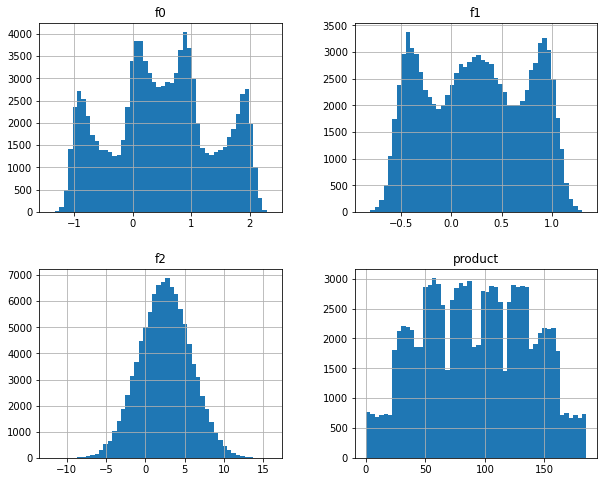

In [13]:
data1.hist(bins=50, figsize=(10,8));

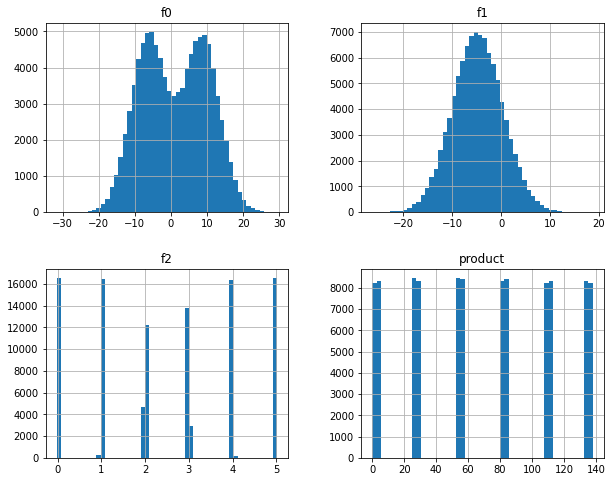

In [14]:
data2.hist(bins=50, figsize=(10,8));

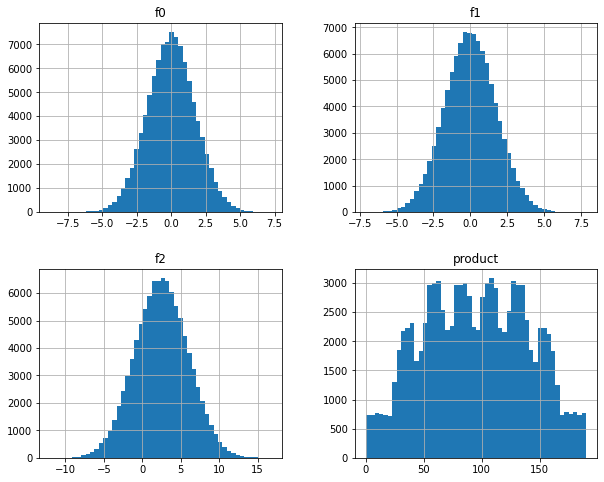

In [15]:
data3.hist(bins=50, figsize=(10,8));

In [16]:
# посчитаем дубликаты в столбце 'product' во втором регионе
data2['product'].duplicated().sum()

99988

In [17]:
# уникальные значения столбца 'product'
data2['product'].unique()

array([  3.17910258,  26.95326103, 134.76630516, 137.94540774,
        84.03888568, 110.99214671,  53.90652206,   0.        ,
       107.81304413,  57.08562465,  30.13236361,  80.85978309])

Во втором регионе всего 12 уникальных значений в столбце 'product', которые повторяются. Скорее всего это связано с измерительным оборудованием (работа оборудования с погрешностью или низкая дискретность) или данные не были получены. И, возможно, данные вводились искусственно.

Посчитаем, сколько нулевых значений в столбце 'product'.

In [18]:
data1[data1['product'] == 0]

,f0,f1,f2,product
57263,-0.702064,0.375992,0.236572,0.0


In [19]:
data2[data2['product'] == 0]

,f0,f1,f2,product
11,16.320755,-0.562946,-0.001783,0.0
13,6.695604,-0.749449,-0.007630,0.0
62,21.418478,-5.134490,-0.002836,0.0
63,6.822701,3.104979,-0.000723,0.0
77,6.750150,-11.893512,-0.001601,0.0
...,...,...,...,...
99936,5.085749,-3.980305,0.005063,0.0
99948,8.277805,-9.178818,0.003275,0.0
99956,13.343983,-1.290200,0.005980,0.0
99961,13.854163,-11.528089,-0.005556,0.0


In [20]:
data3[data3['product'] == 0]

,f0,f1,f2,product
68149,-0.865596,-1.615247,-4.126441,0.0


Во втором регионе более 8% нулевых данных об объемах запасов в скважинах, что еще раз показывает, что данные были утеряны или не собраны.

По таблицам и по графикам видим, что значения одних и тех же признаков для разных регионов абсолютно разные, как и их распределения. Есть нормальные распределения, есть с множественными "пиками", а есть дискретные. Скорее всего это связано с географическими различиями исследуемых районов: например горы и равнины или богатые черноземом почвы и сухие выжженные степи.

Данные об объеме запасов в скважинах положительные или 0.

Все данные в датасетах остались численные, значит преобразование OHE не нужно.

### Разбитие данных на выборки

В данном проекте просят разбить данные на обучающую и валидационную выборки в соотношении 75:25. В реальном проекте я бы разбила данные на 3 (+ тестовая для итоговой проверки модели), так как наличие тестовой выборки повышает уверенность разработчика в качестве построенной им модели. 

На обучающей выборке будем обучать модель архитектурой Линейной регрессии, а на валидационной выборке проверять модель на качество.

Для начала нужно создать переменные для признаков и целевого признака из наших датасетов. Целевой признак в данном проекте - объем запасов в скважине - столбец "product". Создадим нужные нам переменные.

In [21]:
features1 = data1.drop('product', axis=1)
target1 = data1['product']

features2 = data2.drop('product', axis=1)
target2 = data2['product']

features3 = data3.drop('product', axis=1)
target3 = data3['product']

Теперь разобьем данные на 2 выборки (обучающую и валидационную) в пропорции 75% и 25% для каждого из датасетов.

In [22]:
# функция для разбивки на выборки
def split(features, target):
    features_train, features_valid, target_train, target_valid = \
    train_test_split(features, target, train_size=.75, random_state=12345)
    return features_train, features_valid, target_train, target_valid

In [23]:
features1_train, features1_valid, target1_train, target1_valid = split(features1, target1)
features2_train, features2_valid, target2_train, target2_valid = split(features2, target2)
features3_train, features3_valid, target3_train, target3_valid = split(features3, target3)

In [24]:
# проверка одной из выборок
features1_train.shape

(75000, 3)

### Масштабирование признаков

Стандартизуем численные признаки с помощью StandardScaler.

In [25]:
# зафиксируем все численные признаки
numeric = ['f0', 'f1', 'f2']

In [26]:
# убрать предупреждение SettingWithCopy от библиотек pandas и sklearn
pd.options.mode.chained_assignment = None

# создадим объект структуры StandardScaler и настроим его на обучающих данных
scaler = StandardScaler()

# для первого региона
scaler.fit(features1_train[numeric])
# масштабируем численные признаки на всех выборках 
features1_train[numeric] = scaler.transform(features1_train[numeric])
features1_valid[numeric] = scaler.transform(features1_valid[numeric])

# для второго региона
scaler.fit(features2_train[numeric])
features2_train[numeric] = scaler.transform(features2_train[numeric])
features2_valid[numeric] = scaler.transform(features2_valid[numeric])

# для третьего региона
scaler.fit(features3_train[numeric])
features3_train[numeric] = scaler.transform(features3_train[numeric])
features3_valid[numeric] = scaler.transform(features3_valid[numeric])

Мы подготовили исходные датасеты к машинному обучению:

- изучили размер датасетов, строки и ячейки
- проверили на дубликаты, пропуски
- удалили ненужные для обучения модели столбцы
- разбили датасеты на 2 выборки
- масштабировали численные данные

## Обучение и проверка модели

### Обучение модели

Обучим модель Линейной регрессии и посчитаем средний запас предсказанного сырья одной скважины для каждого региона.

In [27]:
model = LinearRegression()

In [28]:
# функция считает RMSE для модели и средний запас предсказанного сырья
def rmse(features_train, target_train, features_valid, target_valid):
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    rmse = mean_squared_error(target_valid, predicted_valid, squared=False)
    mean_pred_stock = predicted_valid.mean()
    mean_fact_stock = target_valid.mean()
    return rmse, mean_pred_stock, mean_fact_stock, predicted_valid

In [29]:
# для первого региона
rmse1, mean_pred_stock1, mean_fact_stock1, predicted_valid1 = rmse(features1_train, \
                                            target1_train, features1_valid, target1_valid)

In [30]:
print(f'RMSE модели первого региона: {rmse1:,.2f}')
print(f'Средний запас предсказанного сырья: {mean_pred_stock1:,.2f}')
print(f'Средний запас фактического сырья: {mean_fact_stock1:,.2f}')

RMSE модели первого региона: 37.58
Средний запас предсказанного сырья: 92.59
Средний запас фактического сырья: 92.08


In [31]:
# для второго региона
rmse2, mean_pred_stock2, mean_fact_stock2, predicted_valid2 = rmse(features2_train, \
                                            target2_train, features2_valid, target2_valid)

In [32]:
print(f'RMSE модели второго региона: {rmse2:,.2f}')
print(f'Средний запас предсказанного сырья: {mean_pred_stock2:,.2f}')
print(f'Средний запас фактического сырья: {mean_fact_stock2:,.2f}')

RMSE модели второго региона: 0.89
Средний запас предсказанного сырья: 68.73
Средний запас фактического сырья: 68.72


In [33]:
# для третьего региона
rmse3, mean_pred_stock3, mean_fact_stock3, predicted_valid3 = rmse(features3_train, \
                                            target3_train, features3_valid, target3_valid)

In [34]:
print(f'RMSE модели третьего региона: {rmse3:,.2f}')
print(f'Средний запас предсказанного сырья: {mean_pred_stock3:,.2f}')
print(f'Средний запас фактического сырья: {mean_fact_stock3:,.2f}')

RMSE модели третьего региона: 40.03
Средний запас предсказанного сырья: 94.97
Средний запас фактического сырья: 94.88


,RMSE,Mean pred. stock,Mean fact stock
1 регион,37.579422,92.592568,92.078597
2 регион,0.893099,68.728547,68.723136
3 регион,40.029709,94.965046,94.884233


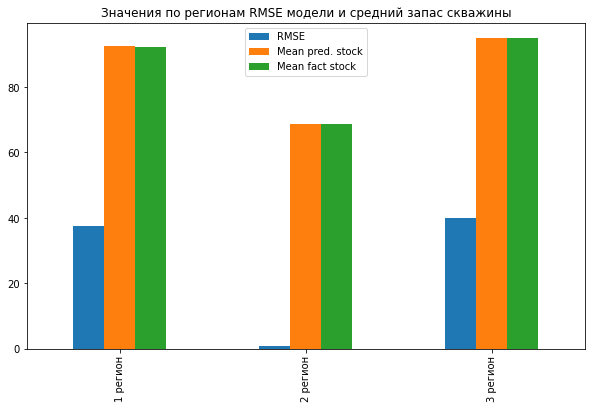

In [35]:
rmse_stock = pd.DataFrame(
    index=['1 регион', '2 регион', '3 регион'],
    data={
        'RMSE': [rmse1, rmse2, rmse3],
        'Mean pred. stock': [mean_pred_stock1, mean_pred_stock2, mean_pred_stock3],
        'Mean fact stock': [mean_fact_stock1, mean_fact_stock2, mean_fact_stock3]
    }
)
display(rmse_stock)

rmse_stock.plot(kind='bar', title='Значения по регионам RMSE модели и средний запас скважины', \
                legend=True, figsize=(10,6));

Среднеквадратичная ошибка меньше всего у модели для второго региона, она близка к нулю. То есть модель практически не ошибается при предсказании объемов запаса скважины. Но также в этом регионе средний запас предсказанного сырья в скважинах значительно меньше, чем в других регионах. Возможно, модель переобучилась из-за недостоверных/нехватающих данных.

В первом и третьем регионах значения RMSE и средние фактические и предсказанные запасы сырья примерно одинаковы.

### Проверка модели 

Проверим наши обученные модели, посчитав RMSE для константной модели, которая каждому объекту прогнозирует среднее значение целевого признака (в нашем случае объем запасов в скважине).

In [36]:
model = LinearRegression()

In [37]:
# функция считает RMSE для константной модели
def rmse_const(features_train, target_train, target_valid):
    model.fit(features_train, target_train)
    predicted_valid = pd.Series([target_train.mean()] * len(target_valid))
    rmse_const = mean_squared_error(target_valid, predicted_valid, squared=False)
    print(f'RMSE константной модели для региона: {rmse_const:,.2f}')

In [38]:
# для первого региона
print(f'RMSE модели первого региона: {rmse1:,.2f}')
rmse_const(features1_train, target1_train, target1_valid)

RMSE модели первого региона: 37.58
RMSE константной модели для региона: 44.29


In [39]:
# для второго региона
print(f'RMSE модели второго региона: {rmse2:,.2f}')
rmse_const(features2_train, target2_train, target2_valid)

RMSE модели второго региона: 0.89
RMSE константной модели для региона: 46.02


In [40]:
# для третьего региона
print(f'RMSE модели третьего региона: {rmse3:,.2f}')
rmse_const(features3_train, target3_train, target3_valid)

RMSE модели третьего региона: 40.03
RMSE константной модели для региона: 44.90


Во всех регионах RMSE константной модели намного выше, чем в обученной. Модели прошли проверку на адекватность.

## Подготовка к расчёту прибыли

Для дальнейших расчетов создадим переменные с имеющимися данными.

In [41]:
BUDGET = 10_000_000_000 # бюджет на разработку скважин в регионе
PRICE = 450_000 # доход с каждой единицы продукта нефти (с 1 тысячи баррелей в рублях)
POINT = 500 # при разведке региона исследуют кол-во точек
POINT_BEST = 200 # выбранные точки для разработки из всех исследуемых

Для начала рассчитаем усредненный достаточный объём сырья для безубыточной разработки новой скважины, зная бюджет и количество выбранных скважин.

In [42]:
average_volume_per_point = BUDGET / POINT_BEST / PRICE
print(f'Достаточный объём сырья для безубыточной разработки новой скважины: \
{average_volume_per_point:,.2f} тыс.баррелей' )

Достаточный объём сырья для безубыточной разработки новой скважины: 111.11 тыс.баррелей


In [43]:
print('Средний запас фактичекой нефти на скважину в первом регионе:', round(target1_valid.mean(), 2))
print('Средний запас фактичекой нефти на скважину во втором регионе:', round(target2_valid.mean(), 2))
print('Средний запас фактичекой нефти на скважину в третьем регионе:', round(target3_valid.mean(), 2))

Средний запас фактичекой нефти на скважину в первом регионе: 92.08
Средний запас фактичекой нефти на скважину во втором регионе: 68.72
Средний запас фактичекой нефти на скважину в третьем регионе: 94.88


In [44]:
# функция для вывода гистограммы распределения по объему скважин
def hist_volume(predicted_valid, number_region):
    predicted_valid = pd.Series(predicted_valid)
    ax = predicted_valid.hist(bins=100)
    ax.set_xlabel('Объем нефти на скважину')
    ax.set_ylabel('Количество скважин')
    ax.set_title(f'Распределение по объему скважин в регионе {number_region}');

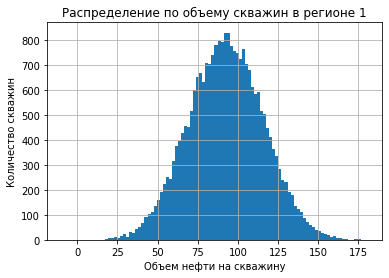

In [45]:
# первый регион
hist_volume(predicted_valid1, 1)

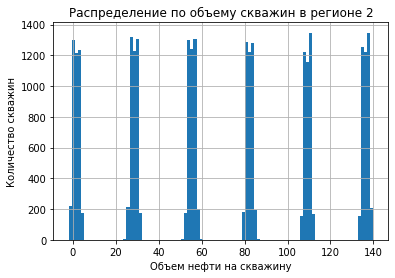

In [46]:
# второй регион
hist_volume(predicted_valid2, 2)

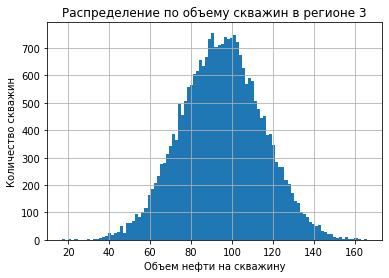

In [47]:
# третий регион
hist_volume(predicted_valid3, 3)

In [48]:
target2_valid.describe()

count    25000.000000
mean        68.723136
std         46.022165
min          0.000000
25%         26.953261
50%         57.085625
75%        107.813044
max        137.945408
Name: product, dtype: float64

In [49]:
target2_valid.quantile(0.76)

110.992146709366

<b>Вывод</b>

Посчитаны средние фактические запасы нефти для всех регионов. Минимальный объем нефти для безубыточной разработки составил 111.11 тыс.баррелей. 

Для первого и третьего регионов есть высокая вероятность окупить затраты: разброс значений вокруг среднего 92 и 95 говорит нам о том, что существует достаточно много скважин, где запасы больше необходимого среднего.

Во втором регионе среднее значение достаточно низкое (68.8). Есть значения выше 111, но их не так много в отличие от других регионов. Только 24% скважин имеют запасы 111 и более тыс.баррелей. Если в выборку лучших скважин (200 из 500) попадут такие скважины, то тоже есть шанс получить безубыточную разработку.

## Расчёт прибыли и рисков 

Создадим функцию для подсчета прибыли по выбранным скважинам и предсказаниям модели. 
Нужно:
- выбрать скважины с максимальными значениями предсказаний
- просуммировать целевое значение объёма сырья, соответствующее этим предсказаниям
- рассчитать прибыль для полученного объёма сырья

In [50]:
def revenue(target, probabilities, point_best):
    probs_sorted = pd.Series(probabilities).sort_values(ascending=False)[:point_best]
    selected = target.reset_index(drop = True)[probs_sorted.index]
    rev = PRICE * selected.sum() - BUDGET
    return round(rev,2)

In [51]:
rev1 = revenue(target1_valid, predicted_valid1, POINT_BEST)
rev2 = revenue(target2_valid, predicted_valid2, POINT_BEST)
rev3 = revenue(target3_valid, predicted_valid3, POINT_BEST)

In [52]:
print("Прибыль с лучших 200 скважин в первом регионе:", rev1)
print("Прибыль с лучших 200 скважин во втором регионе:", rev2)
print("Прибыль с лучших 200 скважин в третьем регионе:", rev3)

Прибыль с лучших 200 скважин в первом регионе: 3320826043.14
Прибыль с лучших 200 скважин во втором регионе: 2415086696.68
Прибыль с лучших 200 скважин в третьем регионе: 2710349963.6


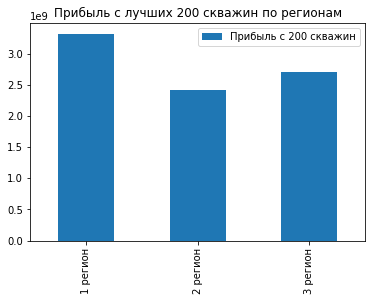

In [53]:
rev_200 = pd.DataFrame(
    index=['1 регион', '2 регион', '3 регион'],
    data={
        'Прибыль с 200 скважин': [rev1, rev2, rev3],
    }
)
rev_200.plot(kind='bar', title='Прибыль с лучших 200 скважин по регионам');

Больше всего прибыли с 200 скважин может принести первый регион. Меньше всего - второй регион.

А теперь посчитаем риски для каждого региона. Применим технику Bootstrap с 1000 выборками, чтобы найти распределение прибыли.
Найдем среднюю прибыль по регионам, 95% доверительный интервал и процент риска.

In [56]:
state = np.random.RandomState(12345)
def bootstrap(target, probabilities):
    values = []
    lost = 0
    for i in range(1000):
        target_sample = target.reset_index(drop = True).sample(replace=True, \
                                                               random_state=state, n=POINT)
        probs_sample = probabilities[target_sample.index]
        profit = revenue(target_sample, probs_sample, POINT_BEST)
        if profit < 0:
            lost +=1
        values.append(profit)
        
    values = pd.Series(values)
    lower = round(values.quantile(0.025),2)
    upper = round(values.quantile(0.975),2)
    average = round(values.mean(),2)
    risk = lost / 1000 * 100
    return average, lower, upper, risk

In [57]:
average1, lower1, upper1, risk1 = bootstrap(target1_valid, predicted_valid1)
print('Средняя прибыль по первому региону:', average1)
print(f'95% доверительный интервал: ({lower1}, {upper1}) тыс.руб.')
print(f'Процент риска {risk1}%')

Средняя прибыль по первому региону: 396164984.8
95% доверительный интервал: (-111215545.89, 909766941.55) тыс.руб.
Процент риска 6.9%


In [58]:
average2, lower2, upper2, risk2 = bootstrap(target2_valid, predicted_valid2)
print('Средняя прибыль по второму региону:', average2)
print(f'95% доверительный интервал: ({lower2}, {upper2}) тыс.руб.')
print(f'Процент риска {risk2}%')

Средняя прибыль по второму региону: 461155817.28
95% доверительный интервал: (78050810.75, 862952060.26) тыс.руб.
Процент риска 0.7000000000000001%


In [59]:
average3, lower3, upper3, risk3 = bootstrap(target3_valid, predicted_valid3)
print('Средняя прибыль по второму региону:', average3)
print(f'95% доверительный интервал: ({lower3}, {upper3}) тыс.руб.')
print(f'Процент риска {risk3}%')

Средняя прибыль по второму региону: 392950475.17
95% доверительный интервал: (-112227625.38, 934562914.55) тыс.руб.
Процент риска 6.5%


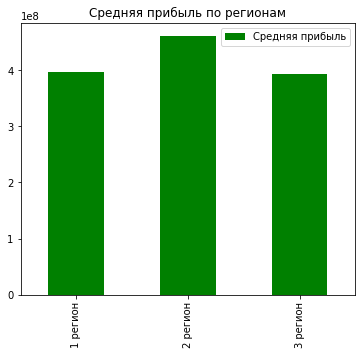

In [60]:
total_rev = pd.DataFrame(
    index=['1 регион', '2 регион', '3 регион'],
    data={
        'Средняя прибыль': [average1, average2, average3]
    }
)
total_rev.plot(kind='bar', title='Средняя прибыль по регионам', figsize=(6, 5), color='g');

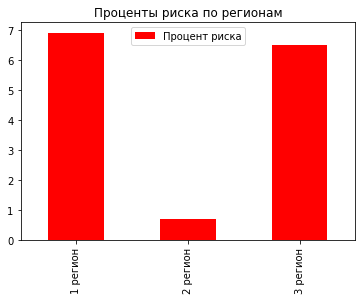

In [61]:
total_risk = pd.DataFrame(
    index=['1 регион', '2 регион', '3 регион'],
    data={
        'Процент риска': [risk1, risk2, risk3]
    }
)
total_risk.plot(kind='bar', title='Проценты риска по регионам', color='r');

Сделав необходимые вычисления, можно сделать следующие выводы:
- предполагаемая средняя прибыль больше всего во втором регионе
- самые низкие риски также во втором регионе: всего 0.7%. Первый и третий регион не подходят по условию, что вероятность убытков должна быть не выше 2.5%
- доверительный интервал второго региона также показывает, что даже при не самых удачных выбранных скважинах разработка в целом окупится 

<b>Итог</b>: выбираем второй регион.

## Выводы

В ходе данного проекта было сделано:
- подготовлены и изучены данные по трем регионам
- обучены и проверены модели архитектурой Линейная регрессия
- посчитаны средние фактические запасы нефти для всех регионов
- сделаны расчеты по средней прибыли, рискам разработки, расчитан 95% доверительный интервал
- выбран лучший из трех регионов (с максимальной прибылью и меньшими рисками) для добычи нефти

Второй регион имеет лучшие показатели, хотя данные, на которых обучалась модель, могут быть не совсем корректны или созданы искусственно.